# Cong Workbook


### Import Libraries
Let's first import some stuff

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [241]:
!pip install mysql-connector-python

In [242]:
import mysql.connector

In [243]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Loading SQL Queries

In [244]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [245]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [246]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [247]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [248]:
tmd['release_date'] = pd.to_datetime(tmd['release_date'])

In [249]:
tmd = tmd.drop_duplicates(subset='title',keep=False)

In [250]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres,
    start_year
FROM movies.imdb_title_basics""", con))

In [251]:
imdb_title_basics['title_new'] = imdb_title_basics['primary_title'].apply(lambda x: x.replace(' ',''))
imdb_title_basics['title_new'] = imdb_title_basics['title_new'].apply(lambda x: x.lower())
imdb_title_basics['title_new_year'] = imdb_title_basics['title_new'] + imdb_title_basics['start_year'].astype(str)

In [302]:
# SELECT *
# FROM movies.imdb_title_basics
# JOIN movies.imdb_title_ratings USING (tconst)
#to compare ImDB genre to ratings 

In [303]:
# SELECT
# 	nconst,
#     tconst,
#     ordering,
#     category,
#     primary_title,
#     start_year,
#     genres,
#     primary_name,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_principals
# JOIN movies.imdb_title_basics USING (tconst)
# JOIN movies.imdb_name_basics USING (nconst)
# JOIN movies.imdb_title_ratings USING (tconst)
# WHERE start_year >= 2015
#to show which actresses / actors / directors appeared in most highly rated movies since 2015

In [304]:
# tn = pd.DataFrame(pd.read_sql_query("""
# SELECT Count(*)
# 	tconst,
#     primary_title,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_ratings
# JOIN movies.imdb_title_basics USING (tconst)""", con))
# to join with tbi to get ratings vs. box office success correlation

### Worldwide Gross by Genre and Season

In [252]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [253]:
# JOIN tb with tmd
tbt = tb.join(
        tmd.set_index('title'),
        on='movie',
        how='left',
        rsuffix='_tmd')

In [254]:
tbt['release_date'] = np.where(tbt['release_date'].isna(), tbt['release_date_tmd'], tbt['release_date']) 

In [255]:
tbt = tbt.drop(columns='release_date_tmd')

In [256]:
tbt['year'] = np.where(tbt['release_date'].isna(), tbt['year'], tbt['release_date'].dt.year)
tbt['movie_new'] = tbt['movie'].apply(lambda x: x.replace(' ',''))
tbt['movie_new'] = tbt['movie_new'].apply(lambda x: x.lower())
tbt['movie_new_year'] = tbt['movie_new'] + tbt['year'].astype(str)
tbt['movie_new_year'] = tbt['movie_new_year'].apply(lambda x: x.replace('.0','')) 

In [257]:
# JOIN tbt with imdb_title_basics
tbi = tbt.join(imdb_title_basics.set_index('title_new_year'),
        on='movie_new_year',
        how='left',
        rsuffix='_imdb')

In [258]:
tbi = tbi.drop_duplicates(subset = 'movie')

In [259]:
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi[['genre1','genre2','genre3']] = tbi['genres'].str.split(pat=',',expand=True)a
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [260]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [261]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [262]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [263]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [264]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [265]:
tbi = tbi.drop(columns=['year','start_year','movie_new'])

In [269]:
tbi.loc[tbi['movie'] == 'Cake']

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,movie_new_year,primary_title,genres,title_new,genre1,genre2,genre3,release_month,release_year,global_mom
NaN,NaN,2014-12-31,Cake,NaN,2.0,NaN,NaN,6.3,9.317,cake2014,Cake,Drama,cake,Drama,None,None,12.0,2014.0,NaN


### Execution

In [270]:
tbi_since1990 = tbi.loc[tbi['release_year'] > 1989]

In [271]:
tbi_since1990.groupby(['genre1']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,release_month,release_year,global_mom
genre1,,,,,,,,,,
Action,50.615385,79.127473,72.541301,227.043053,160.816489,6.129218,14.662453,6.820244,2014.089005,2.618996
Adventure,46.288344,82.018405,88.758974,262.745946,187.428571,6.368182,13.933727,7.497436,2014.271795,3.219012
Animation,43.111111,42.555556,51.764706,181.250000,142.222222,5.806667,7.183933,8.588235,2013.647059,3.276667
Biography,51.640351,23.868421,27.205882,66.204380,45.252632,6.781343,9.944806,8.494118,2014.729412,inf
Comedy,52.501639,22.514754,26.830396,60.967828,37.398438,6.080893,8.709251,7.134066,2013.210989,inf
Crime,48.500000,24.067568,21.529412,55.582278,30.036364,6.275294,10.568659,8.421569,2013.980392,2.407183
Documentary,46.321429,10.000000,4.719512,15.960000,14.733333,7.038889,5.005361,7.337349,2013.313253,inf
Drama,52.158915,18.573643,17.936118,52.402556,38.252688,6.467273,8.400864,7.710784,2013.681373,inf
Family,60.333333,36.166667,84.000000,214.166667,8.000000,4.833333,4.776333,8.333333,2014.833333,2.097500


In [272]:
genre_vs_mom = tbi_since1990.groupby(['genre1']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [273]:
genre2_vs_mom = tbi_since1990.groupby(['genre2']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [274]:
genre_vs_mom

genre1
Mystery        4.450
Horror         3.950
Adventure      2.620
Romance        2.540
Comedy         2.275
Action         2.135
Animation      2.080
Biography      1.915
Drama          1.880
Fantasy        1.655
Crime          1.560
Documentary    1.430
Music          0.500
Sci-Fi         0.360
Family         0.260
Musical        0.170
Thriller       0.000
Western        0.000
Name: global_mom, dtype: float64

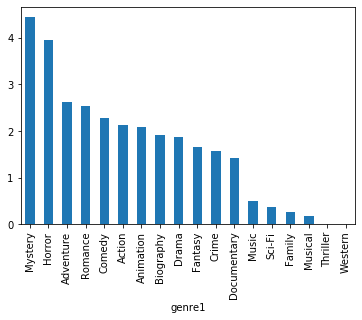

In [275]:
genre_vs_mom.plot.bar()

In [276]:
genre2_vs_mom

genre2
Documentary    6.000
Sci-Fi         4.550
Mystery        4.440
Music          3.180
Animation      2.800
Biography      2.720
Horror         2.675
Romance        2.625
Adventure      2.600
Fantasy        2.095
Family         2.030
Comedy         2.025
Drama          1.910
Sport          1.905
Thriller       1.740
Crime          1.630
War            1.330
Western        1.330
History        0.830
Musical        0.000
Name: global_mom, dtype: float64

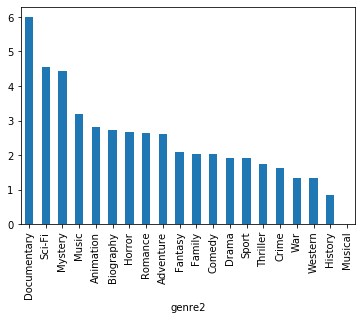

In [277]:
genre2_vs_mom.plot.bar()

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)